## import data and libraries

In [125]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import math

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA version: 12.1
GPU device: NVIDIA GeForce RTX 3050 Ti Laptop GPU
GPU memory: 4.3 GB


In [126]:
class ModelNetCustomDataset(Dataset):
    def __init__(self, train: bool, classes=None, debug=True):
        self.debug = debug
        
        if train:
            x = torch.load("../data/ModelNet_subset/train_x.pt", weights_only=True)
            y = torch.load("../data/ModelNet_subset/train_y.pt", weights_only=True)
        else:
            x = torch.load("../data/ModelNet_subset/test_x.pt", weights_only=True)
            y = torch.load("../data/ModelNet_subset/test_y.pt", weights_only=True)

        # Load class names
        raw_dir = r"C:\Users\snevi\OneDrive\Documents\coding\AI\deep_learning\data\ModelNet\raw"
        self.class_names = sorted([
            name for name in os.listdir(raw_dir)
            if os.path.isdir(os.path.join(raw_dir, name))
        ])

        # Initialize mappings
        self.class_mapping = None
        self.reverse_mapping = None
        self.original_classes = classes

        if self.debug:
            print(f"Original data shapes: x={x.shape}, y={y.shape}")
            print(f"Original label range: [{y.min()}, {y.max()}]")
            print(f"Classes to filter: {classes}")

        # Filter classes FIRST, then standardize the filtered data
        if classes is not None:
            x, y = self.filter_classes(x, y, classes)
            
            if self.debug:
                print(f"After filtering: x={x.shape}, y={y.shape}")
                print(f"Filtered label range: [{y.min()}, {y.max()}]")

            # Create mapping from original class IDs to new contiguous IDs
            self.class_mapping = {original_id: new_id for new_id, original_id in enumerate(sorted(classes))}
            self.reverse_mapping = {new_id: original_id for original_id, new_id in self.class_mapping.items()}
            
            if self.debug:
                print(f"Class mapping: {self.class_mapping}")
            
            # Remap class IDs to be contiguous [0, 1, 2, ..., len(classes)-1]
            y = self.remap_classes(y)
            
            if self.debug:
                print(f"After remapping: label range [{y.min()}, {y.max()}]")
                print(f"Expected range: [0, {len(classes)-1}]")

        # Apply standardization to the (potentially filtered) data
        self.x = self.standardise(x)
        self.y = y
        
        if self.debug:
            print(f"Final dataset: x={self.x.shape}, y={self.y.shape}")
            print(f"Final label range: [{self.y.min()}, {self.y.max()}]")
        
    def remap_classes(self, y):
        """Remap original class IDs to contiguous range [0, 1, 2, ...]"""
        y_remapped = torch.zeros_like(y)
        for i in range(len(y)):
            original_class = y[i].item()
            if original_class not in self.class_mapping:
                raise ValueError(f"Class {original_class} not found in mapping {self.class_mapping}")
            new_class = self.class_mapping[original_class]
            y_remapped[i] = new_class
        return y_remapped

    def standardise(self, x):
        standardised_data = torch.zeros_like(x)
        for i in range(x.shape[0]):
            obj = x[i]
            mean_x = obj.mean(dim=0)
            std_x = obj.std()
            standardised_data[i] = (obj - mean_x) / (std_x + 1e-8)
        return standardised_data

    def filter_classes(self, x, y, classes):
        indices_to_keep = []
        for idx in range(len(y)):
            if y[idx].item() in classes:
                indices_to_keep.append(idx)
        
        if len(indices_to_keep) == 0:
            raise ValueError(f"No samples found for classes {classes}")
        
        x_selected = torch.index_select(x, dim=0, index=torch.tensor(indices_to_keep))
        y_selected = torch.index_select(y, dim=0, index=torch.tensor(indices_to_keep))
        return x_selected, y_selected

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        point_cloud = self.x[idx]
        class_id = self.y[idx]

        # Get original class name using reverse mapping
        if self.reverse_mapping is not None:
            original_class_id = self.reverse_mapping[class_id.item()]
            label = self.class_names[original_class_id]
        else:
            label = self.class_names[class_id.item()]
        
        return point_cloud, class_id, label

In [127]:
#selected_classes = [0, 5, 6, 7, 8, 10, 19, 24, 26, 30, 32, 33, 34, 35, 37]
all_classes = [i for i in range(0,40)]
poor_classes = [24,39,1,21,36,12,23,3,10,15,11,38,29,13,27]
selected_classes = [i for i in all_classes if i not in poor_classes]
NUM_CLASSES = len(selected_classes)
train_dataset = ModelNetCustomDataset(train=True, classes=selected_classes, debug=False)
test_dataset = ModelNetCustomDataset(train=False, classes=selected_classes, debug=False)

BATCH_SIZE = 32
EPOCHS = 30
INPUT_SHAPE = (200, 3)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

device = "cuda" if torch.cuda.is_available() else "cpu"

## steps

In [128]:
def accuracy_fn(y_pred,y_true):
    """
    Calculate accuracy of predictions
    Args:
        y_pred: Predictions from model (logits)
        y_true: True labels
    Returns:
        Accuracy as a percentage
    """
    # Get predicted class indices by taking argmax along the last dimension
    y_pred_indices = torch.argmax(y_pred, dim=1)
    
    # Compare with true labels and calculate accuracy
    correct = (y_pred_indices == y_true).sum().item()
    total = y_true.size(0)
    
    return correct / total * 100  # Return accuracy as percentage

In [129]:
def train_step(
        model: nn.Module,
        data_loader: DataLoader,
        loss_fn: nn.Module,
        optimiser: torch.optim.Optimizer,
        accuracy_fn,
        device: torch.device = device):

    train_loss, train_acc = 0, 0
    model.to(device)
    model.train()
    
    print(f"training loop on {device}...")
    
    for batch, (X, y, names) in enumerate(data_loader):
        
        try:
            # Move data to device
            X, y = X.to(device), y.to(device)
            
            # Fix label shape
            if y.dim() > 1:
                y = y.squeeze()
            y=y.long()

            # Forward pass
            y_pred = model(X)
            
            # Loss and accuracy
            loss = loss_fn(y_pred, y)
            acc = accuracy_fn(y_pred, y)
            
            train_loss += loss.item()
            train_acc += acc
            
            # Backward
            optimiser.zero_grad()
            loss.backward()
            
            # Update
            optimiser.step()

            if batch % 400 == 0:
                print(f"TRAIN: Processed {batch * len(X)}/{len(data_loader.dataset)} samples")
            
        except Exception as e:
            print(f"   ❌ Error in batch {batch + 1}: {e}")
            import traceback
            traceback.print_exc()
            break
    
    # Calculate averages
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    return train_loss, train_acc


In [130]:
def test_step(
        model: nn.Module,
        data_loader: DataLoader,
        loss_fn: nn.Module,
        accuracy_fn,
        device: torch.device = device
):
        test_loss, test_acc = 0, 0
        model.to(device)
        model.eval()  # Set model to evaluation mode
        with torch.inference_mode():  # No gradients needed for inference
            try:
                for batch, (X, y, names) in enumerate(data_loader):
                    X, y = X.to(device), y.to(device)

                    if y.dim() > 1:
                        y = y.squeeze()  # Converts [64, 1] to [64]
                    y=y.long()
                    
                    y_pred = model(X)

                    loss = loss_fn(y_pred, y)
                    acc = accuracy_fn(y_pred, y)

                    test_loss += loss.item()
                    test_acc += acc

                    if batch % 400 == 0:
                        print(f"Processed {batch * len(X)}/{len(data_loader.dataset)} samples")
            except Exception as e:
                print(f"   ❌ Error in batch {batch + 1}: {e}")
                import traceback
                traceback.print_exc()

            # Average loss per batch per epoch
            test_loss /= len(data_loader)
            test_acc /= len(data_loader)
            print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")
        return test_loss, test_acc

In [131]:
def train_model(model,epochs):
    train_accs,test_accs,train_losses,test_losses=[],[],[],[]
    loss_fn= nn.CrossEntropyLoss()
    optimiser = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  # Added weight decay for regularisation

    for epoch in tqdm(range(epochs)):
        print(f"\nEpoch {epoch+1}/{epochs}")
        
        # Train step
        train_loss, train_acc = train_step(
            model=model,
            data_loader=train_dataloader,
            loss_fn=loss_fn,
            optimiser=optimiser,
            accuracy_fn=accuracy_fn,
            device=device
        )
        
        # Test step
        test_loss, test_acc = test_step(
            model=model,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device
        )
        
        # Store metrics
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
    
    return train_accs, test_accs, train_losses, test_losses


In [132]:
def plot_acc_losses(
        model_name: str,
        train_accs: list,
        test_accs: list,
        train_losses: list,
        test_losses: list,
        epochs: int = 7
):
        f,(ax1,ax2)=plt.subplots(1,2)
        f.set_size_inches(15,5)
        ax1.plot(np.arange(1,epochs+1,1),test_accs,label="Test Accuracies")
        ax1.plot(np.arange(1,epochs+1,1),train_accs, label="Train Accuracies")
        ax1.set_title(f"{model_name} Accuracies")
        ax1.legend()
        ax1.set_ylabel("Accuracies (%)")
        ax1.set_xlabel("Epochs")

        ax2.plot(np.arange(1,epochs+1,1),test_losses, label="Test Losses")
        ax2.plot(np.arange(1,epochs+1,1),train_losses, label="Train Losses")
        ax2.set_title(f"{model_name} Losses")
        ax2.legend()
        ax2.set_ylabel("Losses")
        ax2.set_xlabel("Epochs")
    

## models

In [133]:
class SingleHeadSelfAttention(nn.Module):
    """
    x: (B, N, E)
      E = embed_dim (input feature size per token)
      d_k = query/key size
      d_v = value size (can differ from d_k)
    Returns: (B, N, out_dim) where out_dim defaults to d_v unless specified.
    """
    def __init__(self,
                 embed_dim: int,
                 d_k: int,
                 d_v: int,
                 out_dim: int | None = None,
                 p_drop: float = 0.0):
        super().__init__()
        self.q_proj = nn.Linear(embed_dim, d_k)
        self.k_proj = nn.Linear(embed_dim, d_k)
        self.v_proj = nn.Linear(embed_dim, d_v)

        # if want to keep the same width as the rest of the model (e.g., embed_dim), set out_dim=embed_dim; otherwise it will output size d_v.
        self.out_dim = d_v if out_dim is None else out_dim
        self.out_proj = (
            nn.Identity() if self.out_dim == d_v else nn.Linear(d_v, self.out_dim)
        )

        #/ torch.sqrt(torch.tensor(self.hidden_dim)) creates new CPU tensor every forward
        self.scale = 1.0 / math.sqrt(d_k)  # scale by sqrt(d_k) (constant scaling factor)

        #dropout for attention probabilities - randomly zeroes fraction p and rescales rest by 1/(1-p) (Pytorch inverted dropout)
        #encourages model not to rely on single sharp attention pattern to improve generalisation
        self.attn_drop = nn.Dropout(p_drop)

        #feature dropout on per-token features produced by attention - randomly zeros elements of output vectors
        self.proj_drop = nn.Dropout(p_drop)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, N, E)
        q = self.q_proj(x)                     # (B, N, d_k)
        k = self.k_proj(x)                     # (B, N, d_k)
        v = self.v_proj(x)                     # (B, N, d_v)

        #calculate attention weights
        # k.T flips all dims, including batch -> only need to transpose last two dims
        # k:(B,N,H) -> k.T:(H,N,B), but k.transpose(-2,-1): (B,H,N)
        # (B,N,H) @ (B,H,N) -> (B,N,N)
        scores = (q @ k.transpose(-2, -1)) * self.scale  # (B, N, N)
        attn = torch.softmax(scores, dim=-1)             # (B, N, N)
        attn = self.attn_drop(attn)

        y = attn @ v                                     # (B, N, d_v)
        y = self.out_proj(y)                             # (B, N, out_dim)
        y = self.proj_drop(y)
        return y

In [134]:
class SingleHeadClassifier(nn.Module):
    """
    Minimal single-head attention classifier for point clouds.
    Input: (B, N, 3)

    -- attn(d_k,d_v,out_dim) --> (B,N,out_dim)
    -- mean pooling --> (B,out_dim)
    -- linear --> (B, num_classes)

    Output: (B, num_classes) logits
    """
    def __init__(self, 
            num_classes:int,
            embed_dim: int = 64,
            d_k: int = 64,
            d_v: int = 64,
            out_dim: int = 64,
            p_drop: float = 0.1):
        
        super().__init__()

        #takes each point's raw coords (x,y,z) and lifts them into richer feature space of size embed_dim
        #3 numbers too limited for attention to learn useful relations
        #small MLP creates more expressive per-point features


        self.embed=nn.Sequential(
            nn.Linear(3,embed_dim),

            #GELU = Gaussian Error Linear Unit = smooth activarion, like ReLU but with smoother graident
            nn.GELU(),
            nn.Linear(embed_dim,embed_dim)
        )

        self.attn = SingleHeadSelfAttention(
            embed_dim=embed_dim, d_k=d_k, d_v=d_v, out_dim=out_dim, p_drop=p_drop
        )

        #if ever switch back to mean-only, change the head to nn.Linear(out_dim, num_classes)
        self.head = nn.Linear(2 * out_dim, num_classes) 

    def forward(self, x):
        x=self.embed(x)         # (B, N, embed_dim)
        x = self.attn(x)            # (B, N, out_dim)

        #mean pool over points, averages over N points
        #symmetric reduction - permutation-invariant as reordering points does not change mean - important as point cloud is an unordered set
        #smooth, noise tolerant summary
        feat_mean = x.mean(dim=1)        # (B, out_dim) 

        #max pool over points, takes max over N points
        #takes strongest activation per channel to pick out edge like features
        feat_max = x.amax(dim=1)   # (B, out_dim)

        #global pooling - fuses smooth global trends and extremes -> gives small accuracy boost
        feat = torch.cat([feat_mean,feat_max],dim=-1) # (B, 2*out_dim)

        #pooled feature goes through linear layer to produce class logits suitable for nn.CrossEntropyLoss
        logits = self.head(feat)    # (B, num_classes)
        return logits


## test

In [135]:
attention_model = SingleHeadClassifier(
    num_classes=NUM_CLASSES,
    d_k=32, d_v=32, out_dim=32,     # small but effective starting point
    p_drop=0.1
).to(device)

In [136]:
(train_accs, test_accs,
 train_losses, test_losses) = train_model(attention_model, epochs=EPOCHS)

  0%|          | 0/30 [00:00<?, ?it/s]


Epoch 1/30
training loop on cuda...
TRAIN: Processed 0/7628 samples


  3%|▎         | 1/30 [00:01<00:37,  1.29s/it]

Train loss: 2.26378 | Train accuracy: 35.32%
Processed 0/1846 samples
Test loss: 1.82948 | Test accuracy: 44.06%

Epoch 2/30
training loop on cuda...
TRAIN: Processed 0/7628 samples


  7%|▋         | 2/30 [00:02<00:29,  1.05s/it]

Train loss: 1.48792 | Train accuracy: 57.41%
Processed 0/1846 samples
Test loss: 1.60987 | Test accuracy: 50.53%

Epoch 3/30
training loop on cuda...
TRAIN: Processed 0/7628 samples


 10%|█         | 3/30 [00:03<00:27,  1.03s/it]

Train loss: 1.28074 | Train accuracy: 64.10%
Processed 0/1846 samples
Test loss: 1.47247 | Test accuracy: 55.04%

Epoch 4/30
training loop on cuda...
TRAIN: Processed 0/7628 samples


 13%|█▎        | 4/30 [00:04<00:25,  1.02it/s]

Train loss: 1.17126 | Train accuracy: 66.80%
Processed 0/1846 samples
Test loss: 1.48087 | Test accuracy: 58.25%

Epoch 5/30
training loop on cuda...
TRAIN: Processed 0/7628 samples


 17%|█▋        | 5/30 [00:05<00:24,  1.02it/s]

Train loss: 1.11005 | Train accuracy: 68.80%
Processed 0/1846 samples
Test loss: 1.37728 | Test accuracy: 63.61%

Epoch 6/30
training loop on cuda...
TRAIN: Processed 0/7628 samples


 20%|██        | 6/30 [00:06<00:23,  1.01it/s]

Train loss: 1.05744 | Train accuracy: 70.54%
Processed 0/1846 samples
Test loss: 1.31933 | Test accuracy: 65.38%

Epoch 7/30
training loop on cuda...
TRAIN: Processed 0/7628 samples


 23%|██▎       | 7/30 [00:06<00:21,  1.05it/s]

Train loss: 1.02121 | Train accuracy: 71.45%
Processed 0/1846 samples
Test loss: 1.30857 | Test accuracy: 66.23%

Epoch 8/30
training loop on cuda...
TRAIN: Processed 0/7628 samples


 27%|██▋       | 8/30 [00:07<00:20,  1.07it/s]

Train loss: 0.98518 | Train accuracy: 72.30%
Processed 0/1846 samples
Test loss: 1.32674 | Test accuracy: 64.96%

Epoch 9/30
training loop on cuda...
TRAIN: Processed 0/7628 samples


 30%|███       | 9/30 [00:08<00:19,  1.09it/s]

Train loss: 0.95524 | Train accuracy: 73.67%
Processed 0/1846 samples
Test loss: 1.22997 | Test accuracy: 67.77%

Epoch 10/30
training loop on cuda...
TRAIN: Processed 0/7628 samples


 33%|███▎      | 10/30 [00:09<00:17,  1.12it/s]

Train loss: 0.95876 | Train accuracy: 72.97%
Processed 0/1846 samples
Test loss: 1.30025 | Test accuracy: 63.48%

Epoch 11/30
training loop on cuda...
TRAIN: Processed 0/7628 samples


 37%|███▋      | 11/30 [00:10<00:16,  1.13it/s]

Train loss: 0.92735 | Train accuracy: 73.73%
Processed 0/1846 samples
Test loss: 1.23099 | Test accuracy: 65.45%

Epoch 12/30
training loop on cuda...
TRAIN: Processed 0/7628 samples


 40%|████      | 12/30 [00:11<00:15,  1.14it/s]

Train loss: 0.90270 | Train accuracy: 74.30%
Processed 0/1846 samples
Test loss: 1.29040 | Test accuracy: 64.23%

Epoch 13/30
training loop on cuda...
TRAIN: Processed 0/7628 samples


 43%|████▎     | 13/30 [00:12<00:14,  1.15it/s]

Train loss: 0.88882 | Train accuracy: 74.83%
Processed 0/1846 samples
Test loss: 1.22895 | Test accuracy: 66.17%

Epoch 14/30
training loop on cuda...
TRAIN: Processed 0/7628 samples


 47%|████▋     | 14/30 [00:13<00:13,  1.14it/s]

Train loss: 0.87569 | Train accuracy: 75.54%
Processed 0/1846 samples
Test loss: 1.29833 | Test accuracy: 62.65%

Epoch 15/30
training loop on cuda...
TRAIN: Processed 0/7628 samples


 50%|█████     | 15/30 [00:13<00:13,  1.14it/s]

Train loss: 0.87827 | Train accuracy: 74.92%
Processed 0/1846 samples
Test loss: 1.30251 | Test accuracy: 64.27%

Epoch 16/30
training loop on cuda...
TRAIN: Processed 0/7628 samples


 53%|█████▎    | 16/30 [00:14<00:12,  1.14it/s]

Train loss: 0.85554 | Train accuracy: 75.04%
Processed 0/1846 samples
Test loss: 1.24855 | Test accuracy: 65.30%

Epoch 17/30
training loop on cuda...
TRAIN: Processed 0/7628 samples


 57%|█████▋    | 17/30 [00:15<00:11,  1.11it/s]

Train loss: 0.81955 | Train accuracy: 76.69%
Processed 0/1846 samples
Test loss: 1.30843 | Test accuracy: 65.13%

Epoch 18/30
training loop on cuda...
TRAIN: Processed 0/7628 samples


 60%|██████    | 18/30 [00:16<00:10,  1.11it/s]

Train loss: 0.82258 | Train accuracy: 76.26%
Processed 0/1846 samples
Test loss: 1.41888 | Test accuracy: 61.99%

Epoch 19/30
training loop on cuda...
TRAIN: Processed 0/7628 samples


 63%|██████▎   | 19/30 [00:17<00:09,  1.12it/s]

Train loss: 0.88337 | Train accuracy: 75.19%
Processed 0/1846 samples
Test loss: 1.40737 | Test accuracy: 61.37%

Epoch 20/30
training loop on cuda...
TRAIN: Processed 0/7628 samples


 67%|██████▋   | 20/30 [00:18<00:09,  1.10it/s]

Train loss: 0.83086 | Train accuracy: 75.99%
Processed 0/1846 samples
Test loss: 1.38558 | Test accuracy: 63.81%

Epoch 21/30
training loop on cuda...
TRAIN: Processed 0/7628 samples


 70%|███████   | 21/30 [00:19<00:08,  1.06it/s]

Train loss: 0.78195 | Train accuracy: 77.53%
Processed 0/1846 samples
Test loss: 1.22696 | Test accuracy: 66.17%

Epoch 22/30
training loop on cuda...
TRAIN: Processed 0/7628 samples


 73%|███████▎  | 22/30 [00:20<00:07,  1.07it/s]

Train loss: 0.76728 | Train accuracy: 78.20%
Processed 0/1846 samples
Test loss: 1.18642 | Test accuracy: 67.11%

Epoch 23/30
training loop on cuda...
TRAIN: Processed 0/7628 samples


 77%|███████▋  | 23/30 [00:21<00:06,  1.08it/s]

Train loss: 0.76061 | Train accuracy: 78.48%
Processed 0/1846 samples
Test loss: 1.24113 | Test accuracy: 67.03%

Epoch 24/30
training loop on cuda...
TRAIN: Processed 0/7628 samples


 80%|████████  | 24/30 [00:22<00:05,  1.11it/s]

Train loss: 0.73772 | Train accuracy: 78.39%
Processed 0/1846 samples
Test loss: 1.20631 | Test accuracy: 66.65%

Epoch 25/30
training loop on cuda...
TRAIN: Processed 0/7628 samples


 83%|████████▎ | 25/30 [00:22<00:04,  1.13it/s]

Train loss: 0.72312 | Train accuracy: 79.26%
Processed 0/1846 samples
Test loss: 1.30878 | Test accuracy: 65.63%

Epoch 26/30
training loop on cuda...
TRAIN: Processed 0/7628 samples


 87%|████████▋ | 26/30 [00:23<00:03,  1.15it/s]

Train loss: 0.70562 | Train accuracy: 79.86%
Processed 0/1846 samples
Test loss: 1.38926 | Test accuracy: 65.15%

Epoch 27/30
training loop on cuda...
TRAIN: Processed 0/7628 samples


 90%|█████████ | 27/30 [00:24<00:02,  1.17it/s]

Train loss: 0.70787 | Train accuracy: 79.64%
Processed 0/1846 samples
Test loss: 1.35853 | Test accuracy: 64.69%

Epoch 28/30
training loop on cuda...
TRAIN: Processed 0/7628 samples


 93%|█████████▎| 28/30 [00:25<00:01,  1.17it/s]

Train loss: 0.69056 | Train accuracy: 79.83%
Processed 0/1846 samples
Test loss: 1.32335 | Test accuracy: 64.37%

Epoch 29/30
training loop on cuda...
TRAIN: Processed 0/7628 samples


 97%|█████████▋| 29/30 [00:26<00:00,  1.18it/s]

Train loss: 0.69321 | Train accuracy: 79.90%
Processed 0/1846 samples
Test loss: 1.30628 | Test accuracy: 66.01%

Epoch 30/30
training loop on cuda...
TRAIN: Processed 0/7628 samples


100%|██████████| 30/30 [00:27<00:00,  1.10it/s]

Train loss: 0.67642 | Train accuracy: 80.47%
Processed 0/1846 samples
Test loss: 1.24999 | Test accuracy: 67.12%


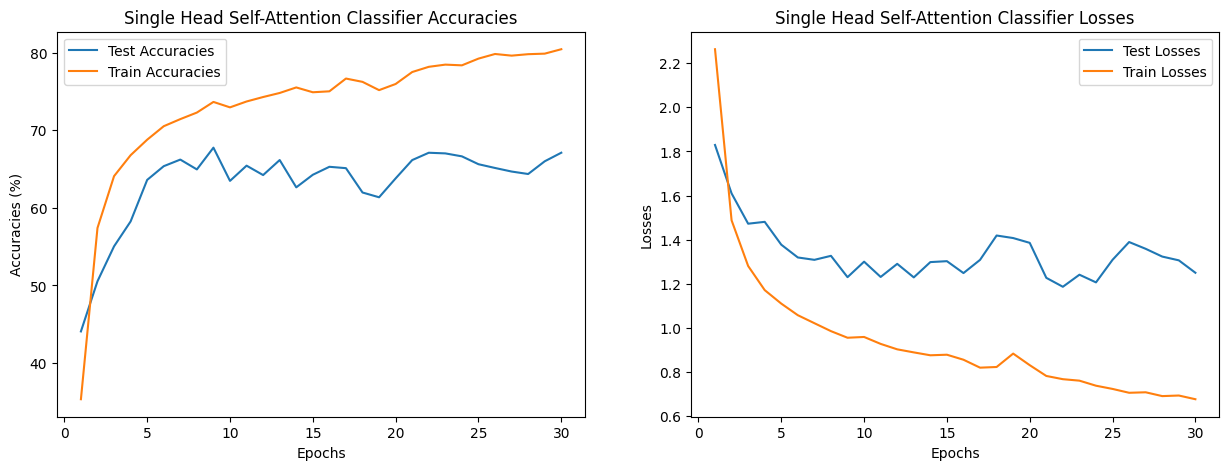

In [137]:
plot_acc_losses(
    model_name="Single Head Self-Attention Classifier",
    train_accs=train_accs,
    test_accs=test_accs,
    train_losses=train_losses,
    test_losses=test_losses,
    epochs=EPOCHS
)

## analysing results

### visual

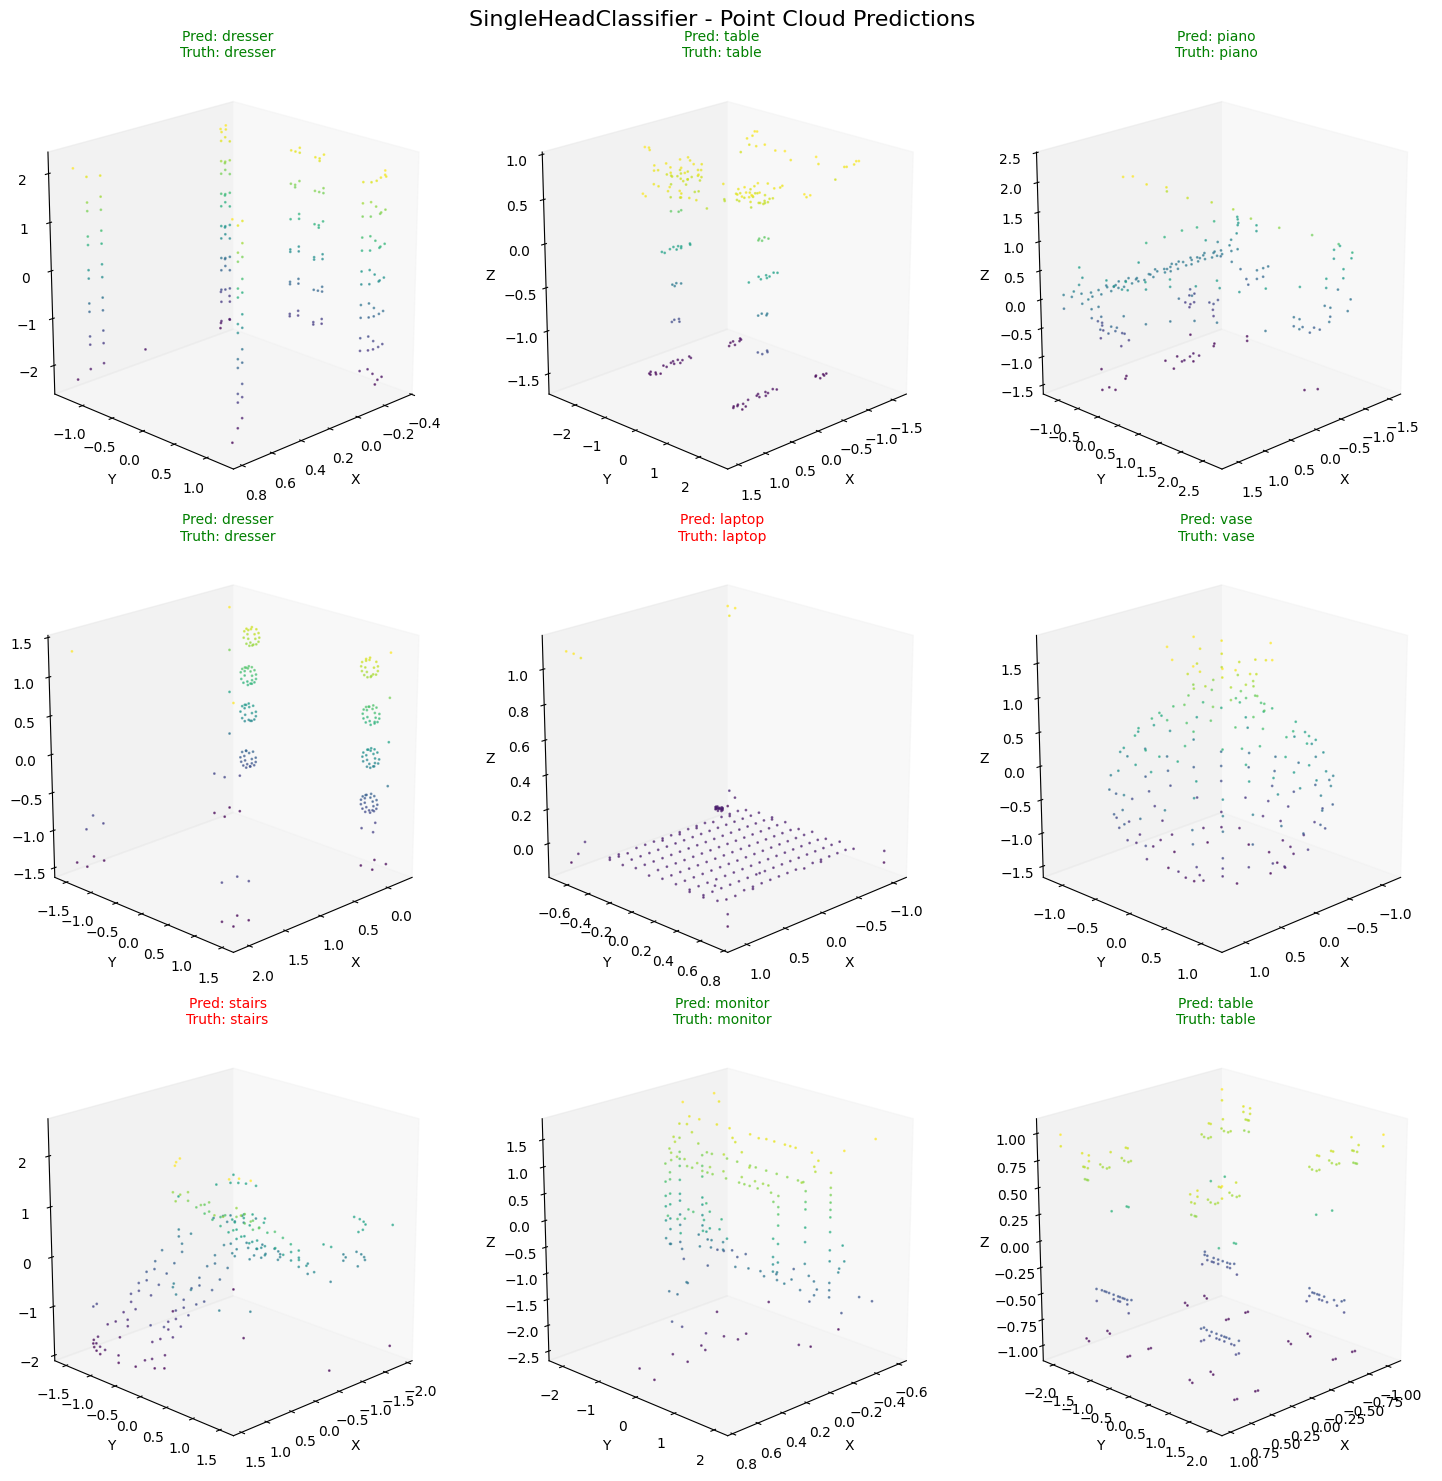

Accuracy on 9 samples: 77.8% (7/9)


In [138]:
def visualise_point_cloud_predictions(
        model: torch.nn.Module,
        test_dataset: Dataset,
        device: torch.device = device,
        k: int = 9
):
    # Sample k random samples from test dataset
    import random
    test_indices = random.sample(range(len(test_dataset)), k=k)
    
    test_samples = []
    test_labels = []
    test_names = []
    
    for idx in test_indices:
        sample, label, name = test_dataset[idx]
        test_samples.append(sample)
        test_labels.append(label.item())
        test_names.append(name)
    
    # Stack samples into batch tensor
    test_batch = torch.stack(test_samples).to(device)
    
    # Make predictions
    model.eval()
    with torch.inference_mode():
        pred_logits = model(test_batch)
        pred_probs = torch.softmax(pred_logits, dim=1)
        pred_classes = pred_probs.argmax(dim=1)
    
    # Move predictions back to CPU for plotting
    pred_classes = pred_classes.cpu()
    
    # Create 3x3 subplot grid
    fig = plt.figure(figsize=(15, 15))
    fig.suptitle(f"{model.__class__.__name__} - Point Cloud Predictions", fontsize=16, y=0.98)
    nrows, ncols = 3, 3
    
    for i, sample in enumerate(test_samples):
        # Create 3D subplot for each point cloud
        ax = fig.add_subplot(nrows, ncols, i+1, projection='3d')
        
        # Get point cloud coordinates (N, 3) -> (x, y, z)
        points = sample.cpu().numpy()
        x, y, z = points[:, 0], points[:, 1], points[:, 2]
        
        # Plot point cloud
        ax.scatter(x, y, z, c=z, cmap='viridis', s=1, alpha=0.6)
        
        # Get prediction and truth labels
        pred_label = test_names[i] if hasattr(test_dataset, 'class_names') else f"Class {pred_classes[i]}"
        truth_label = test_names[i]
        
        # Create title
        title_text = f"Pred: {pred_label}\nTruth: {truth_label}"
        
        # Check for equality and change title color accordingly
        if pred_classes[i] == test_labels[i]:
            ax.set_title(title_text, fontsize=10, color='green')
        else:
            ax.set_title(title_text, fontsize=10, color='red')
        
        # Set axis properties
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        
        # Make axes equal and remove grid for cleaner look
        ax.set_box_aspect([1,1,1])
        ax.grid(False)
        
        # Set viewing angle for better visualization
        ax.view_init(elev=20, azim=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print accuracy for these samples
    correct = (pred_classes == torch.tensor(test_labels)).sum().item()
    accuracy = correct / len(test_labels) * 100
    print(f"Accuracy on {k} samples: {accuracy:.1f}% ({correct}/{len(test_labels)})")

# Usage example:
visualise_point_cloud_predictions(
    model=attention_model,
    test_dataset=test_dataset,
    device=device,
    k=9
)

### stats

In [139]:
@torch.no_grad()
def per_class_accuracy(model, data_loader, num_classes, device):
    model.to(device).eval()

    counts  = torch.zeros(num_classes, dtype=torch.long, device=device)
    correct = torch.zeros(num_classes, dtype=torch.long, device=device)

    for X, y, _ in data_loader:
        X = X.to(device)
        y = y.squeeze(1).long().to(device)

        pred = model(X).argmax(dim=1)          # (B,)

        for c in range(num_classes):
            m = (y == c)                       # (B,)
            counts[c]  += m.sum()
            correct[c] += (pred[m] == c).sum()

    acc = (correct.float() / counts.clamp_min(1).float()).cpu().tolist()
    return acc


In [140]:
# Per-class accuracy on the TEST set
test_acc_by_class = per_class_accuracy(
    model=attention_model,
    data_loader=test_dataloader,
    num_classes=NUM_CLASSES,
    device=device
)
print("Per-class test accuracies (%):", [round(a*100, 2) for a in test_acc_by_class])


Per-class test accuracies (%): [82.0, 60.0, 93.0, 54.0, 60.0, 90.0, 95.0, 65.0, 86.05, 62.0, 50.0, 90.0, 30.0, 10.0, 85.0, 26.0, 38.0, 80.0, 91.0, 10.0, 90.0, 66.0, 20.0, 89.0, 33.0]


In [141]:
# Build index -> class name using the train_dataset mapping
idx2name = [train_dataset.class_names[train_dataset.reverse_mapping[i]]
            for i in range(NUM_CLASSES)]

for i, (name, acc) in enumerate(zip(idx2name, test_acc_by_class)):
    print(f"[{i:02d}] {name:<12} {acc*100:.2f}%")


[00] airplane     82.00%
[01] bed          60.00%
[02] bookshelf    93.00%
[03] bottle       54.00%
[04] bowl         60.00%
[05] car          90.00%
[06] chair        95.00%
[07] cone         65.00%
[08] dresser      86.05%
[09] glass_box    62.00%
[10] guitar       50.00%
[11] keyboard     90.00%
[12] lamp         30.00%
[13] laptop       10.00%
[14] monitor      85.00%
[15] piano        26.00%
[16] plant        38.00%
[17] range_hood   80.00%
[18] sofa         91.00%
[19] stairs       10.00%
[20] stool        90.00%
[21] table        66.00%
[22] tent         20.00%
[23] toilet       89.00%
[24] vase         33.00%


In [142]:
top_10_classes = sorted(
    enumerate(test_acc_by_class), key=lambda x: x[1], reverse=True)[:10]
bottom_10_classes = sorted(
    enumerate(test_acc_by_class), key=lambda x: x[1])[:10]

print("Top 10 classes by accuracy:")
for i, (idx, acc) in enumerate(top_10_classes):
    original_class_id = train_dataset.reverse_mapping[idx]
    class_name = train_dataset.class_names[original_class_id]
    print(f"[{original_class_id:02d}] {class_name:<15} {acc*100:.2f}%")

print("\nBottom 10 classes by accuracy:")
for i, (idx, acc) in enumerate(bottom_10_classes):
    original_class_id = train_dataset.reverse_mapping[idx]
    class_name = train_dataset.class_names[original_class_id]
    print(f"[{original_class_id:02d}] {class_name:<15} {acc*100:.2f}%")

Top 10 classes by accuracy:
[08] chair           95.00%
[04] bookshelf       93.00%
[30] sofa            91.00%
[07] car             90.00%
[18] keyboard        90.00%
[32] stool           90.00%
[35] toilet          89.00%
[14] dresser         86.05%
[22] monitor         85.00%
[00] airplane        82.00%

Bottom 10 classes by accuracy:
[20] laptop          10.00%
[31] stairs          10.00%
[34] tent            20.00%
[25] piano           26.00%
[19] lamp            30.00%
[37] vase            33.00%
[26] plant           38.00%
[17] guitar          50.00%
[05] bottle          54.00%
[02] bed             60.00%


In [143]:

@torch.no_grad()
def confusion_and_top_confusions(model, data_loader, num_classes, device, topk=10):
    model.to(device).eval()
    # Confusion matrix on CPU (rows=true, cols=pred)
    conf = torch.zeros(num_classes, num_classes, dtype=torch.long)

    for X, y, _ in data_loader:
        X = X.to(device)
        y = y.squeeze(1).long()                # keep on CPU for the confusion table
        pred = model(X).argmax(1).cpu()

        # accumulate counts
        for t, p in zip(y.tolist(), pred.tolist()):
            conf[t, p] += 1

    # collect off-diagonal pairs (true!=pred)
    pairs = []
    cm = conf.numpy()
    for t in range(num_classes):
        for p in range(num_classes):
            if t == p: 
                continue
            c = int(cm[t, p])
            if c > 0:
                pairs.append((t, p, c))

    pairs.sort(key=lambda x: x[2], reverse=True)
    return conf, pairs[:topk]


In [144]:
# index -> readable class name
idx2name = [train_dataset.class_names[train_dataset.reverse_mapping[i]] 
            for i in range(NUM_CLASSES)]

conf, top_pairs = confusion_and_top_confusions(
    model=attention_model,
    data_loader=test_dataloader,
    num_classes=NUM_CLASSES,
    device=device,
    topk=10
)

print("Top misclassifications (true → pred : count):")
for t, p, c in top_pairs:
    print(f"{idx2name[t]:<12} → {idx2name[p]:<12} : {c}")


Top misclassifications (true → pred : count):
guitar       → keyboard     : 45
vase         → stool        : 38
bottle       → stool        : 36
glass_box    → car          : 20
bed          → keyboard     : 19
plant        → stool        : 16
piano        → chair        : 12
piano        → glass_box    : 11
monitor      → dresser      : 10
airplane     → guitar       : 9


In [145]:
import random

@torch.no_grad()
def random_misclass_examples(model, data_loader, idx2name, k=20, device="cpu", seed=42):
    model.to(device).eval()
    pool = []

    for X, y, _ in data_loader:
        X = X.to(device)
        y = y.squeeze(1).long().to(device)

        logits = model(X)
        probs = logits.softmax(dim=1)              # (B, C)
        conf, pred = probs.max(dim=1)              # confidence of predicted class

        mask = (pred != y)
        if mask.any():
            for t, p, c in zip(y[mask].tolist(), pred[mask].tolist(), conf[mask].tolist()):
                pool.append((idx2name[t], idx2name[p], float(c)))

    if not pool:
        return []

    rng = random.Random(seed)
    rng.shuffle(pool)
    return pool[:k]


In [146]:
examples = random_misclass_examples(
    model=attention_model,
    data_loader=test_dataloader,
    idx2name=idx2name,
    k=20,
    device=device,
    seed=0
)

print("\nRandom misclassifications (true, pred, confidence):")
for i, (t, p, c) in enumerate(examples, 1):
    print(f"{i:02d}. true={t:<12} pred={p:<12} conf={c:.2f}")



Random misclassifications (true, pred, confidence):
01. true=piano        pred=stool        conf=0.42
02. true=plant        pred=bookshelf    conf=0.95
03. true=stool        pred=chair        conf=0.86
04. true=bed          pred=guitar       conf=0.38
05. true=plant        pred=vase         conf=0.40
06. true=vase         pred=plant        conf=0.43
07. true=plant        pred=car          conf=0.58
08. true=plant        pred=stool        conf=0.56
09. true=bottle       pred=stool        conf=0.81
10. true=piano        pred=bed          conf=0.32
11. true=bookshelf    pred=glass_box    conf=0.93
12. true=monitor      pred=dresser      conf=0.55
13. true=vase         pred=lamp         conf=0.80
14. true=dresser      pred=bottle       conf=0.64
15. true=car          pred=tent         conf=0.55
16. true=stairs       pred=laptop       conf=0.49
17. true=range_hood   pred=keyboard     conf=1.00
18. true=bottle       pred=stool        conf=0.77
19. true=stairs       pred=bookshelf    conf=0.

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

@torch.no_grad()
def compute_confusion_matrix(model, data_loader, num_classes, device):
    """Return a (C, C) tensor of integer counts. Rows=true, Cols=pred."""
    model.to(device).eval()
    conf = torch.zeros(num_classes, num_classes, dtype=torch.long)  # keep on CPU for counting
    for X, y, _ in data_loader:
        X = X.to(device)
        y = y.squeeze(1).long()          # CPU tensor (we'll count on CPU)
        pred = model(X).argmax(1).cpu()
        for t, p in zip(y.tolist(), pred.tolist()):
            conf[t, p] += 1
    return conf

def plot_confusion_matrix_counts(conf, class_names, title="Confusion Matrix (Counts)"):
    """Plot a single count matrix."""
    C = conf.shape[0]
    fig, ax = plt.subplots(figsize=(8, 7))
    im = ax.imshow(conf, interpolation='nearest', cmap='Blues')
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

    ax.set_xticks(np.arange(C)); ax.set_yticks(np.arange(C))
    ax.set_xticklabels(class_names, rotation=45, ha='right', fontsize=8)
    ax.set_yticklabels(class_names, fontsize=8)

    # annotate counts
    vmax = conf.max().item() if conf.numel() > 0 else 1
    for i in range(C):
        for j in range(C):
            val = int(conf[i, j].item())
            ax.text(j, i, f"{val}", ha='center', va='center',
                    color=("white" if val > 0.5 * vmax else "black"), fontsize=8)

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()
    return fig


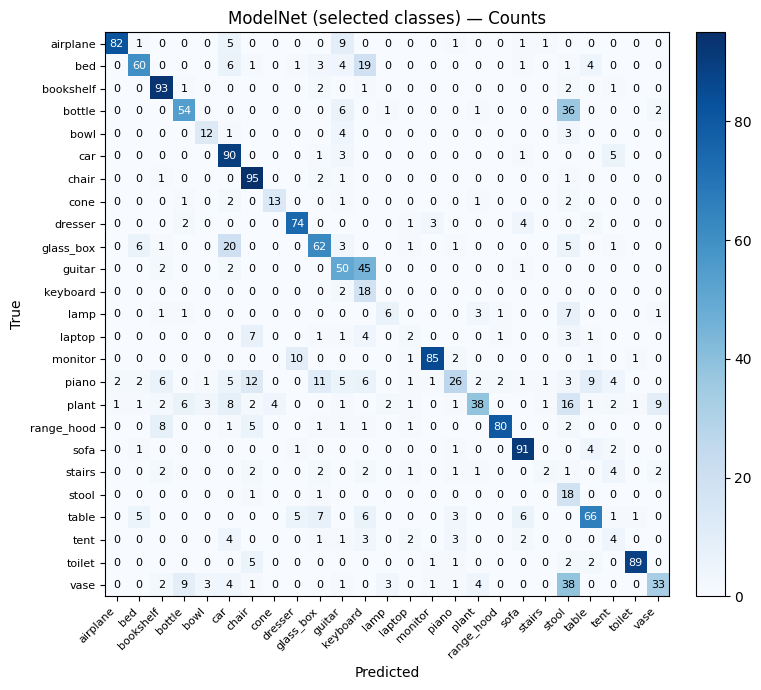

In [150]:
# index -> class name (using your filtered mapping)
idx2name = [train_dataset.class_names[train_dataset.reverse_mapping[i]]
            for i in range(NUM_CLASSES)]

conf = compute_confusion_matrix(
    model=attention_model,
    data_loader=test_dataloader,
    num_classes=NUM_CLASSES,
    device=device
)

_ = plot_confusion_matrix_counts(conf, idx2name, title="ModelNet (selected classes) — Counts")
# Optional: _.savefig("confusion_counts.png", dpi=200, bbox_inches='tight')
